# Problem statement

The goal of the project to help car enthusiast correctly identify which of the two car brands, Toyota and Honda, does his post belong to. In addition to that, it also helps beginnner car ethusiast identify the brand of the car that the subreddit post is writing about, since both cars are Japanese brand, it can be quite confusing for such beginners. 

The type of model that will be developed is a classification model. The model will classify the post into the two different categories, which are Toyota and Honda. The success of the models will be evaluated with two metrics, the accuracy and the f1 score of the model. Accuracy is considered here because we will be using a balanced number of classes in the training and test dateset. F1 score takes into account precision and recall which are vital in identify the true positive in different scenarios which will be further explained in the modelling notebook. 

The audience of this investigation will be the people that are viewing the two subreddits. The primary stakeholders are the car enthusiast and the subreddit moderators who might want to rightly separate the two subreddits since they have many similarities in terms of where the car comes from and the pricing of the cars. The secondary stakeholders would be the moderators running the reddit website that might want a model to automatically sort the post according to the rightful subreddits without having the user to manually input one.

In [2]:
import requests
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import re
import warnings
warnings.filterwarnings('ignore')

In [1]:
def dataretrive(subreddit,length):
    url = "https://api.pushshift.io/reddit/search/submission"
    params = {
    "subreddit" : subreddit,
    "size": 100}
    res = requests.get(url,params)
    data = res.json()
    datadf = pd.DataFrame(data["data"])
    #Check if requests is successful
    if res.status_code != 200:
        return "Try again with another subreddit"
        
    
    #Getting batches of the last retrieved date
    while len(datadf)<length:
        lastdate = datadf.iloc[-1]["created_utc"]
        updateparams = {"subreddit" : subreddit, 
                  "size": 100, #Requesting the size of 100 (Maximum size is 250) 
                  "before": lastdate
                 }
        tempres = requests.get(url,updateparams)
        data = tempres.json()
        datadf = pd.concat([datadf,pd.DataFrame(data["data"])])
    #Getting the time difference 
    
    return datadf

In [1]:
def emptytester(df):
    selftextseries = df["selftext"].value_counts(normalize = True)

    emptycount = 0
    removecount = 0
    deletedcount = 0
    cleandata = df[~df["selftext"].isin(["","[removed]","[deleted]"])]
    if "" in selftextseries.index:
        emptycount = round(selftextseries[""]*100,3)
    if "[removed]" in selftextseries.index:
        removecount = round(selftextseries["[removed]"]*100,3)
    if "[deleted]" in selftextseries.index:
        deletedcount = round(selftextseries["[deleted]"]*100,3)
    
    print(f'The percentage of empty text cell is {emptycount}%.\nThe percentage of removed text cell is {removecount}%.\nThe percentage of deleted text cell is {deletedcount}%.\nThe total number of clean rows is {len(cleandata)}')
    #Removing Hyperlinks (Datacleaning)
    cleandata.loc[:,"selftext"] = cleandata.loc[:,"selftext"].apply(lambda x: re.sub(r'http\S+', '', str(x)))
    #Removing any entries with no text
    cleandata.dropna(subset=["selftext"],inplace = True)
    #Adding both the title and the self text as both provides information
    cleandata["combined"] = cleandata["selftext"] + " " +cleandata["title"]
    #Removing /n for line breaks
    cleandata["combined"] = cleandata["combined"].apply(lambda x: x.replace("/n", " "))
    return cleandata.reset_index()

In [4]:
def checkwords(df,additionalStopWords = [], maxfeatures = 500):
    stop_words = text.ENGLISH_STOP_WORDS.union(additionalStopWords)
    tempdf = df["selftext"] + " " +df["title"]
    cvec = CountVectorizer(max_features = maxfeatures, max_df = 0.98, stop_words = stop_words)
    wordvec = cvec.fit_transform(tempdf)
    vecdf = pd.DataFrame(wordvec.toarray(), columns=cvec.get_feature_names_out())
    vecdf.sum().sort_values(ascending= False).head(10).plot(kind = "barh")
    print(f'The number of words is {len(cvec.get_feature_names_out())}')
    return vecdf

# Honda

In [5]:
#Scraping 1901 number of clean rows without any [removed], [deleted] or empty entries
Honda = dataretrive("Honda",5000)

In [6]:
cleanHonda = emptytester(Honda)

The percentage of empty text cell is 61.46%.
The percentage of removed text cell is 0.42%.
The percentage of deleted text cell is 0.1%.
The total number of clean rows is 1901


>The number of clean rows is quite healthy and is above 1000, therefore we will proceed with this amount of data pulled

In [9]:
cleanHonda["isHonda"] = 1

The number of words is 500


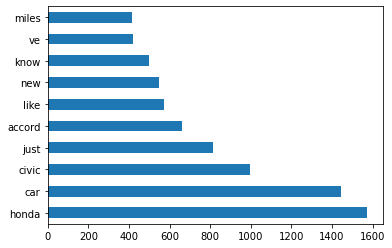

In [10]:
hondaVec = checkwords(cleanHonda)

The number of words is 500


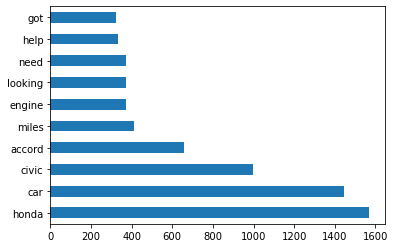

In [11]:
#Adding this stopword that did not get filtered out
stopwords = ["ve","just","new","know","like"]
hondaVec = checkwords(cleanHonda,additionalStopWords = stopwords)

# Toyota

In [ ]:
Toyota = dataretrive("Toyota",5000)

In [ ]:
cleanToyota = emptytester(Toyota)

In [ ]:
cleanToyota["isHonda"] = 0

In [ ]:
toyotaVec = checkwords(cleanToyota)

In [ ]:
combinedf = pd.concat([cleanHonda,cleanToyota]).reset_index()

In [ ]:
combinedf.to_csv("Dataset/HondaToyotadf.csv",index = False)